error_max = 0.00650508314926


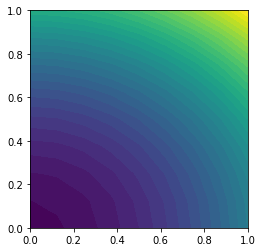

IndexError: list index out of range

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt


from fenics import *
import numpy as np

r_v = 1

def solver_bcs(kappa, f, boundary_conditions, Nx, Ny,
               degree=1,
               subdomains=[],
               linear_solver='lu',
               abs_tol=1E-5,
               rel_tol=1E-3,
               max_iter=1000):
    """
    Solve -div(kappa*grad(u) = f on (0, 1) x (0, 1) with 2*Nx*Ny Lagrange
    elements of specified degree and u = u_D on the boundary. This version
    of the solver uses a specified combination of Dirichlet, Neumann, and
    Robin boundary conditions.
    """

    # Create mesh and define function space
    mesh = UnitSquareMesh(Nx, Ny)
    V = FunctionSpace(mesh, 'P', degree)

    # Check if we have subdomains
    if subdomains:
        if not isinstance(kappa, (list, tuple, np.ndarray)):
            raise TypeError(
                'kappa must be array if we have sudomains, not %s'
                % type(kappa))
        materials = CellFunction('size_t', mesh)
        materials.set_all(0)
        for m, subdomain in enumerate(subdomains[1:], 1):
            subdomain.mark(materials, m)

        kappa_values = kappa
        V0 = FunctionSpace(mesh, 'DG', 0)
        kappa  = Function(V0)
        help = np.asarray(materials.array(), dtype=np.int32)
        kappa.vector()[:] = np.choose(help, kappa_values)
    else:
        if not isinstance(kappa, (Expression, Constant)):
            raise TypeError(
                'kappa is type %s, must be Expression or Constant'
                % type(kappa))

    # Define boundary subdomains
    tol = 1e-14

    class BoundaryX0(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0, tol)

    class BoundaryX1(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 1, tol)

    class BoundaryY0(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], 0, tol)

    class BoundaryY1(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], 1, tol)

    # Mark boundaries
    boundary_markers = MeshFunction('size_t', mesh, mesh.topology().dim() - 1) 
    boundary_markers.set_all(9999)
    bx0 = BoundaryX0()
    bx1 = BoundaryX1()
    by0 = BoundaryY0()
    by1 = BoundaryY1()
    bx0.mark(boundary_markers, 0)
    bx1.mark(boundary_markers, 1)
    by0.mark(boundary_markers, 2)
    by1.mark(boundary_markers, 3)
    
    # Redefine boundary integration measure
    ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

    # Collect Dirichlet conditions
    bcs = []
    for i in boundary_conditions:
        if 'Dirichlet' in boundary_conditions[i]:
            bc = DirichletBC(V, boundary_conditions[i]['Dirichlet'],
                             boundary_markers, i)
            bcs.append(bc)
    print(bcs[0])
    
    debug1 = False
    if debug1:

        # Print all vertices that belong to the boundary parts
        for x in mesh.coordinates():
            if bx0.inside(x, True): print('%s is on x = 0' % x)
            if bx1.inside(x, True): print('%s is on x = 1' % x)
            if by0.inside(x, True): print('%s is on y = 0' % x)
            if by1.inside(x, True): print('%s is on y = 1' % x)

        # Print the Dirichlet conditions
        print('Number of Dirichlet conditions:', len(bcs))
        if V.ufl_element().degree() == 1:  # P1 elements
            d2v = dof_to_vertex_map(V)
            coor = mesh.coordinates()
            for i, bc in enumerate(bcs):
                print('Dirichlet condition %d' % i)
                boundary_values = bc.get_boundary_values()
                for dof in boundary_values:
                    print('   dof %2d: u = %g' % (dof, boundary_values[dof]))
                    if V.ufl_element().degree() == 1:
                        print('    at point %s' %
                              (str(tuple(coor[d2v[dof]].tolist()))))

    # Define trial and test functions
    u = TrialFunction(V)
    v = TestFunction(V)

    # Collect Neumann integrals
    integrals_N = []
    for i in boundary_conditions:
        if 'Neumann' in boundary_conditions[i]:
            if boundary_conditions[i]['Neumann'] != 0:
                g = boundary_conditions[i]['Neumann']
                integrals_N.append(g*v*ds(i))

    # Collect Robin integrals
    integrals_R_a = []
    integrals_R_L = []
    for i in boundary_conditions:
        if 'Robin' in boundary_conditions[i]:
            r, s = boundary_conditions[i]['Robin']
            integrals_R_a.append(r*u*v*ds(i))
            integrals_R_L.append(r*s*v*ds(i))

    # Simpler Robin integrals
    integrals_R = []
    for i in boundary_conditions:
        if 'Robin' in boundary_conditions[i]:
            r, s = boundary_conditions[i]['Robin']
            integrals_R.append(r*(u - s)*v*ds(i))

    # Sum integrals to define variational problem
    a = kappa*dot(grad(u), grad(v))*dx + sum(integrals_R_a) - u * r_v * dx
    L = f*v*dx - sum(integrals_N) + sum(integrals_R_L)

    # Simpler variational problem
    F = kappa*dot(grad(u), grad(v))*dx + sum(integrals_R) - f*v*dx + sum(integrals_N)  - u * r_v * dx
    a, L = lhs(F), rhs(F)

    # Compute solution
    u = Function(V)
    solve(a == L, u, bcs)

    return u

def demo_bcs(case):
    "Compute and plot solution using a combination of boundary conditions"
    mu = Constant(1)
    # Define manufactured solution in sympy and derive f, g, etc.
    import sympy as sym
    x, y = sym.symbols('x[0], x[1]')            # needed by UFL
    u = 1 + 2*x**2 + 3*y**2                       # exact solution
    u_e = u   # exact solution
    f = - sym.diff(u, x, 2) - sym.diff(u, y, 2)   # -Laplace(u)
    f = sym.simplify(f)                         # simplify f
    
    
    if case == 5:
        u_00 = u.subs(x, 0)                         # restrict to x = 0
        u_01 = u.subs(x, 1)                         # restrict to x = 1
        g = -sym.diff(u, y).subs(y, 1)              # compute g = -du/dn
        r = 1000                                    # Robin data, arbitrary
        s = u                                       # Robin data, u = s
         # Collect variables
        variables = [u_e, u_00, u_01, f, g, r, s]

        # Turn into C/C++ code strings
        variables = [sym.printing.ccode(var) for var in variables]

        # Turn into FEniCS Expressions
        variables = [Expression(var, degree=2) for var in variables]

        # Extract variables
        u_e, u_00, u_01, f, g, r, s = variables

        # Define boundary conditions
        boundary_conditions = {0: {'Dirichlet': u_00},   # x = 0
                               1: {'Dirichlet': u_01},   # x = 1
                               2: {'Robin':     (r, s)}, # y = 0
                               3: {'Neumann':   g}}      # y = 1  
    elif case ==1:
        u_00 = u.subs(x, 0)                         # restrict to x = 0
        u_01 = u.subs(x, 1)                         # restrict to x = 1
        u_10 = u.subs(y, 0)                         # restrict to x = 0
        u_11 = u.subs(y, 1)
                  # simplify f
         # Collect variables
        variables = [u_e, u_00, u_01, u_10, u_11, f]

        # Turn into C/C++ code strings
        variables = [sym.printing.ccode(var) for var in variables]

        # Turn into FEniCS Expressions
        variables = [Expression(var, degree=2) for var in variables]

        # Extract variables
        u_e, u_00, u_01, u_10, u_11, f = variables

        # Define boundary conditions
        boundary_conditions = {0: {'Dirichlet': u_00},   # x = 0
                               1: {'Dirichlet': u_01},   # x = 1
                               2: {'Dirichlet': u_10}, # y = 0
                               3: {'Dirichlet': u_11}}      # y = 1  
    elif case ==2:                     
        g_00 = sym.diff(u, x).subs(x, 0)                         
        g_01 = -sym.diff(u, x).subs(x, 1)
        g_10 = sym.diff(u, y).subs(y, 0)                         
        g_11 = -sym.diff(u, y).subs(y, 1)    
                  # simplify f
         # Collect variables
        variables = [u_e, g_00, g_01, g_10, g_11, f]

        # Turn into C/C++ code strings
        variables = [sym.printing.ccode(var) for var in variables]

        # Turn into FEniCS Expressions
        variables = [Expression(var, degree=2) for var in variables]

        # Extract variables
        u_e, g_00, g_01, g_10, g_11, f = variables

        # Define boundary conditions
        boundary_conditions = {0: {'Neumann': g_00},   # x = 0
                               1: {'Neumann': g_01},   # x = 1
                               2: {'Neumann': g_10}, # y = 0
                               3: {'Neumann': g_11}}      # y = 1  
    elif case ==3:                     
        r00 = 1000                                    # Robin data, arbitrary
        s00 = u                                       # Robin data, u = s 
        r10 = 1000                                    # Robin data, arbitrary
        s10 = u       
        r01 = 1
        r11 = 1
        s01 = u + sym.diff(u, y).subs(x, 1)  
        s11 = u + sym.diff(u, y).subs(y, 1)
                  # simplify f
         # Collect variables
        variables = [u_e, r00, s00, r01, s01, r10, s10, r11, s11, f]

        # Turn into C/C++ code strings
        variables = [sym.printing.ccode(var) for var in variables]

        # Turn into FEniCS Expressions
        variables = [Expression(var, degree=2) for var in variables]

        # Extract variables
        u_e, r00, s00, r01, s01, r10, s10, r11, s11, f = variables

        # Define boundary conditions
        boundary_conditions = {0: {'Robin':     (r00, s00)},   # x = 0
                               1: {'Robin':     (r01, s01)},   # x = 1
                               2: {'Robin':     (r10, s10)},   # y = 0
                               3: {'Robin':     (r11, s11)}}   # y = 1
    elif case ==4:                     
        u_00 = u.subs(x, 0)  
        r10 = 1000                                    # Robin data, arbitrary
        s10 = u       
        r11 = 1
        s11 = u + sym.diff(u, y).subs(y, 1)
        g_01 = -sym.diff(u, x).subs(x, 1)
                  # simplify f
         # Collect variables
        variables = [u_e, g_01, u_00, r10, s10, r11, s11, f]

        # Turn into C/C++ code strings
        variables = [sym.printing.ccode(var) for var in variables]

        # Turn into FEniCS Expressions
        variables = [Expression(var, degree=2) for var in variables]

        # Extract variables
        u_e, g_01, u_00, r10, s10, r11, s11, f = variables

        # Define boundary conditions
        boundary_conditions = {0: {'Dirichlet': u_00},   # x = 0
                               1: {'Neumann': g_01},   # x = 1
                               2: {'Robin':     (r10, s10)},   # y = 0
                               3: {'Robin':     (r11, s11)}}   # y = 1
    
    elif case ==6:                     
        u_00 = 1000  
        u_01 = 1000
        g_10 = 0
        g_11 = 0
                  # simplify f
         # Collect variables
        variables = [u_e, g_11, g_11, u_00, u_01, f]

        # Turn into C/C++ code strings
        variables = [sym.printing.ccode(var) for var in variables]

        # Turn into FEniCS Expressions
        variables = [Expression(var, degree=2) for var in variables]

        # Extract variables
        u_e, g_11, g_11, u_00, u_01, f = variables

        # Define boundary conditions
        boundary_conditions = {0: {'Dirichlet': u_00},   # x = 0
                               1: {'Dirichlet': u_01},   # x = 1
                               2: {'Neumann': g_10},   # y = 0
                               3: {'Neumann': g_11}}   # y = 1
    
        

   

    # Compute solution
    
    Nx = Ny = 8
    u = solver_bcs(mu, f, boundary_conditions, Nx, Ny,
                   degree=1, linear_solver='direct')

    # Compute maximum error at vertices
    mesh = u.function_space().mesh()
    vertex_values_u_e = u_e.compute_vertex_values(mesh)
    vertex_values_u = u.compute_vertex_values(mesh)
    error_max = np.max(np.abs(vertex_values_u_e -
                              vertex_values_u))
    print('error_max =', error_max)

    # Save and plot solution
    vtkfile = File('poisson_extended/solution_bcs_' + str(case) + '.pvd')
    vtkfile << u
    plot(u)
#case = int(input('Pick a case: '))
demo_bcs(5)
plt.show()
demo_bcs(2)
plt.show()
demo_bcs(3)
plt.show()
demo_bcs(4)
plt.show()

Neuman boundary conditions on paper

x=0 , $g_N = -4$

x=1 , $g_N = 4$

y=0 , $g_N = -6$

y=1 , $g_N = 6$

Robin boundary conditions on paper

x=0 , $g_R = u(x = 0)$

x=1 , $g_R = 4 + u(x = 1)$

y=0 , $g_R = u(y = 0)$

y=1 , $g_R = 6 + u(y = 1)$